In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Check the current working directory
print("Current working directory:", os.getcwd())

# Load the dataset
guided_X = np.load('guided_dataset_X.npy')
guided_y = np.load('guided_dataset_y.npy')
guided_test_X = np.load('guided_testset_X.npy')

# Print the shapes to understand the data dimensions
print("guided_X shape:", guided_X.shape)
print("guided_y shape:", guided_y.shape)
print("guided_test_X shape:", guided_test_X.shape)

Current working directory: c:\Users\Asus\OneDrive - Université Libre de Bruxelles\Documents\Cours\MA3\Q2\ML\Project\guided
guided_X shape: (5, 8, 230000)
guided_y shape: (5, 51, 230000)
guided_test_X shape: (5, 332, 8, 500)


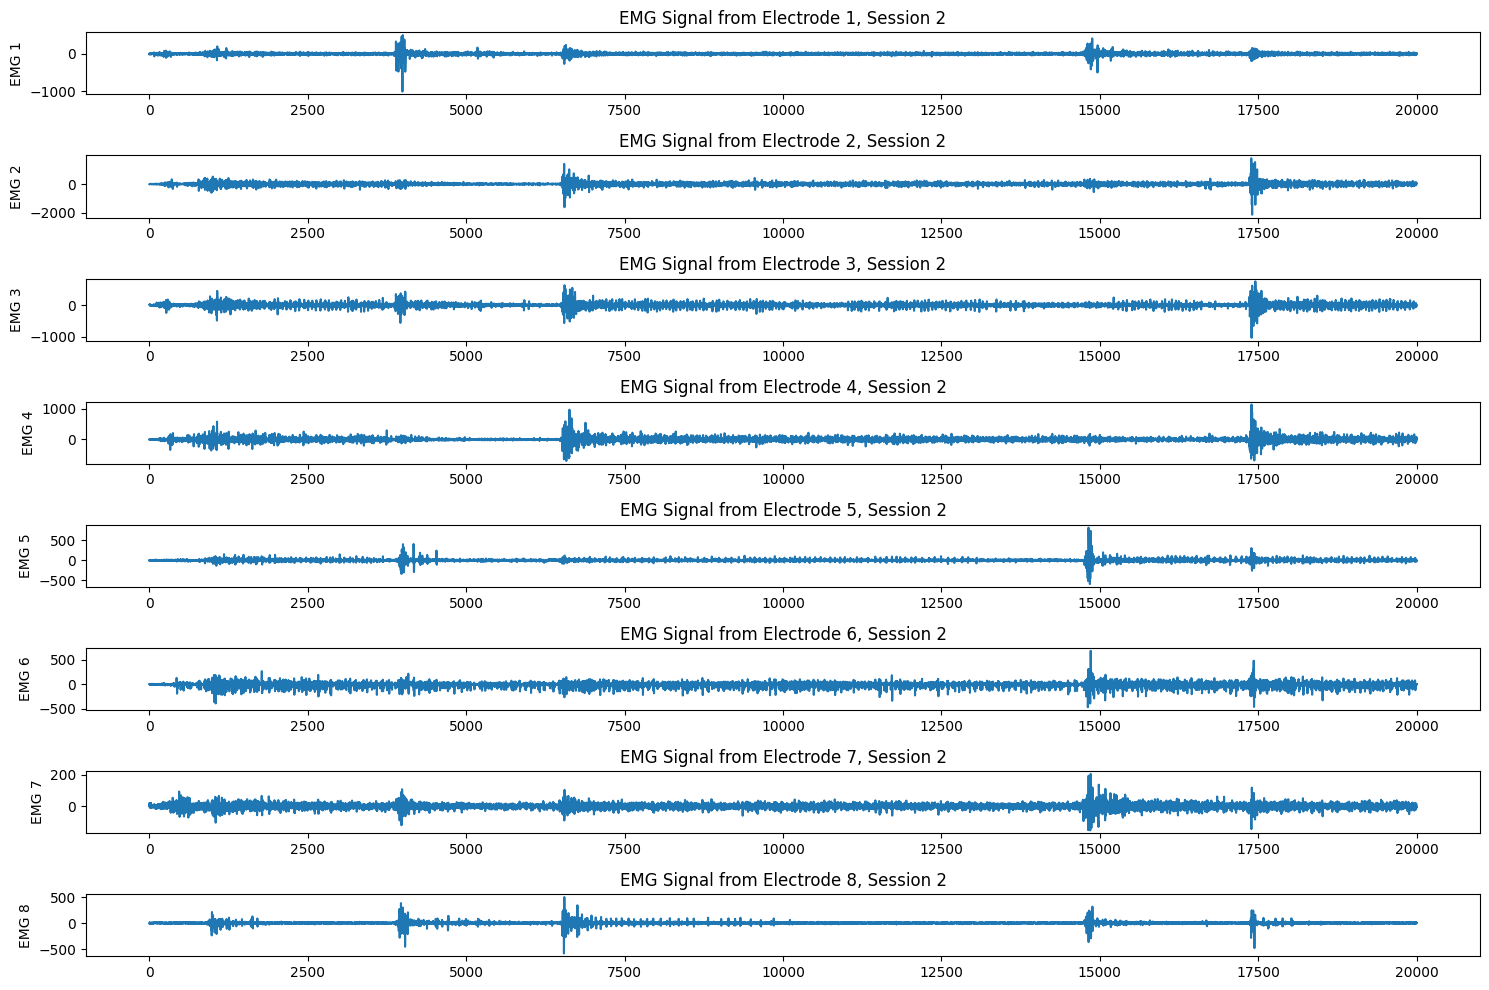

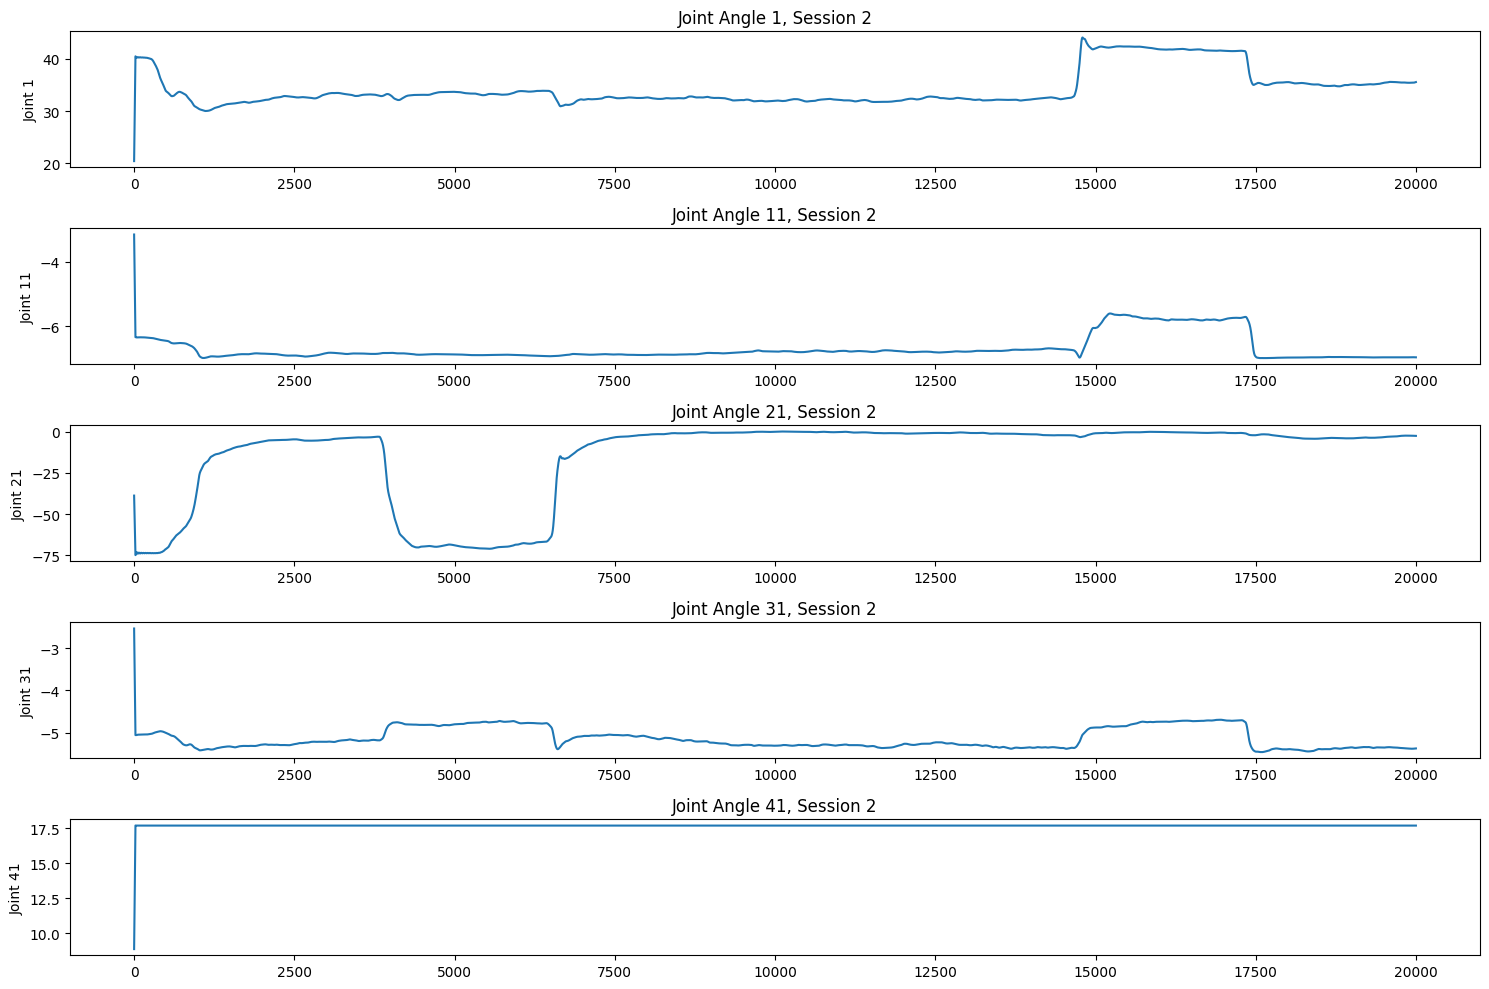

In [11]:
# According to the project description:
# guided_X shape: (5, 8, 230000) - (session, electrode, time)
# guided_y shape: (5, 51, 230000) - (session, joint_angle, time)
# guided_test_X shape: (5, 332, 8, 500) - (session, window, electrode, time)

# Let's examine one session
session_id = 1

# Plot EMG signals from all 8 electrodes for a short time segment
plt.figure(figsize=(15, 10))
time_segment = slice(0, 20000)  # First 5000 samples (about 5 seconds at 1024 Hz)

for electrode in range(8):
    plt.subplot(8, 1, electrode+1)
    plt.plot(guided_X[session_id, electrode, time_segment])
    plt.ylabel(f'EMG {electrode+1}')
    plt.title(f'EMG Signal from Electrode {electrode+1}, Session {session_id+1}')
    
plt.tight_layout()
plt.show()

# Plot a few joint angles for the same time segment
plt.figure(figsize=(15, 10))
for i, joint_id in enumerate([0, 10, 20, 30, 40]):  # Sample a few joints
    plt.subplot(5, 1, i+1)
    plt.plot(guided_y[session_id, joint_id, time_segment])
    plt.ylabel(f'Joint {joint_id+1}')
    plt.title(f'Joint Angle {joint_id+1}, Session {session_id+1}')
    
plt.tight_layout()
plt.show()

First part
Raw EMG signals from 8 electrodes over 20 seconds, could do less to see a smaller sample or more (up to 230).

There are clear and distincts changes in muscle activity around 4000, 7000, 15000,and 17500.

It shows clear muscle activation patterns with good separation from baseline noise, which will help for the future machine learning application. 

As can be seen the moment of clear muscles activation are clearly linked to joint movement, EMG-joint correlations. They align almost perfectly for joint 1 and 11 for example at 15000 and 17500, joint 21 around 4000 and 7000. Same for joint 31 but in less proportion around 4000, 7000, 15000, 17500.


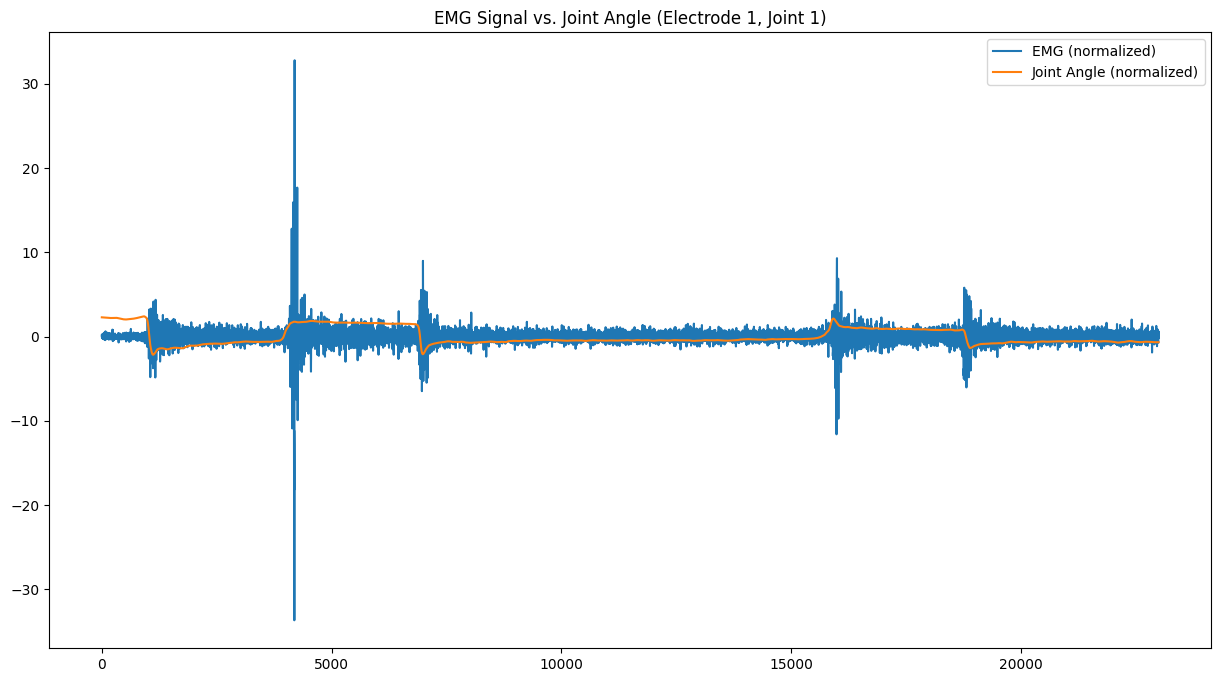

In [8]:
# Pick a short segment to visualize the relationship
plt.figure(figsize=(15, 8))

# Choose one electrode and one joint angle to visualize
electrode_id = 0
joint_id = 0
time_segment = slice(0, 23000)

# Normalize both signals for better visualization
emg_signal = guided_X[session_id, electrode_id, time_segment]
joint_angle = guided_y[session_id, joint_id, time_segment]

emg_normalized = (emg_signal - np.mean(emg_signal)) / np.std(emg_signal)
joint_normalized = (joint_angle - np.mean(joint_angle)) / np.std(joint_angle)

plt.plot(emg_normalized, label='EMG (normalized)')
plt.plot(joint_normalized, label='Joint Angle (normalized)')
plt.legend()
plt.title(f'EMG Signal vs. Joint Angle (Electrode {electrode_id+1}, Joint {joint_id+1})')
plt.show()

Here is a more striking visualisation of the relationship between Electrode-1 (EMG = electromyographie) and the joint movements.

Around 1000, 4000, 7500, 17500, 19000 there are clear EMG activity spikes where the joint angle become to decrease or increase showing a clear correlation

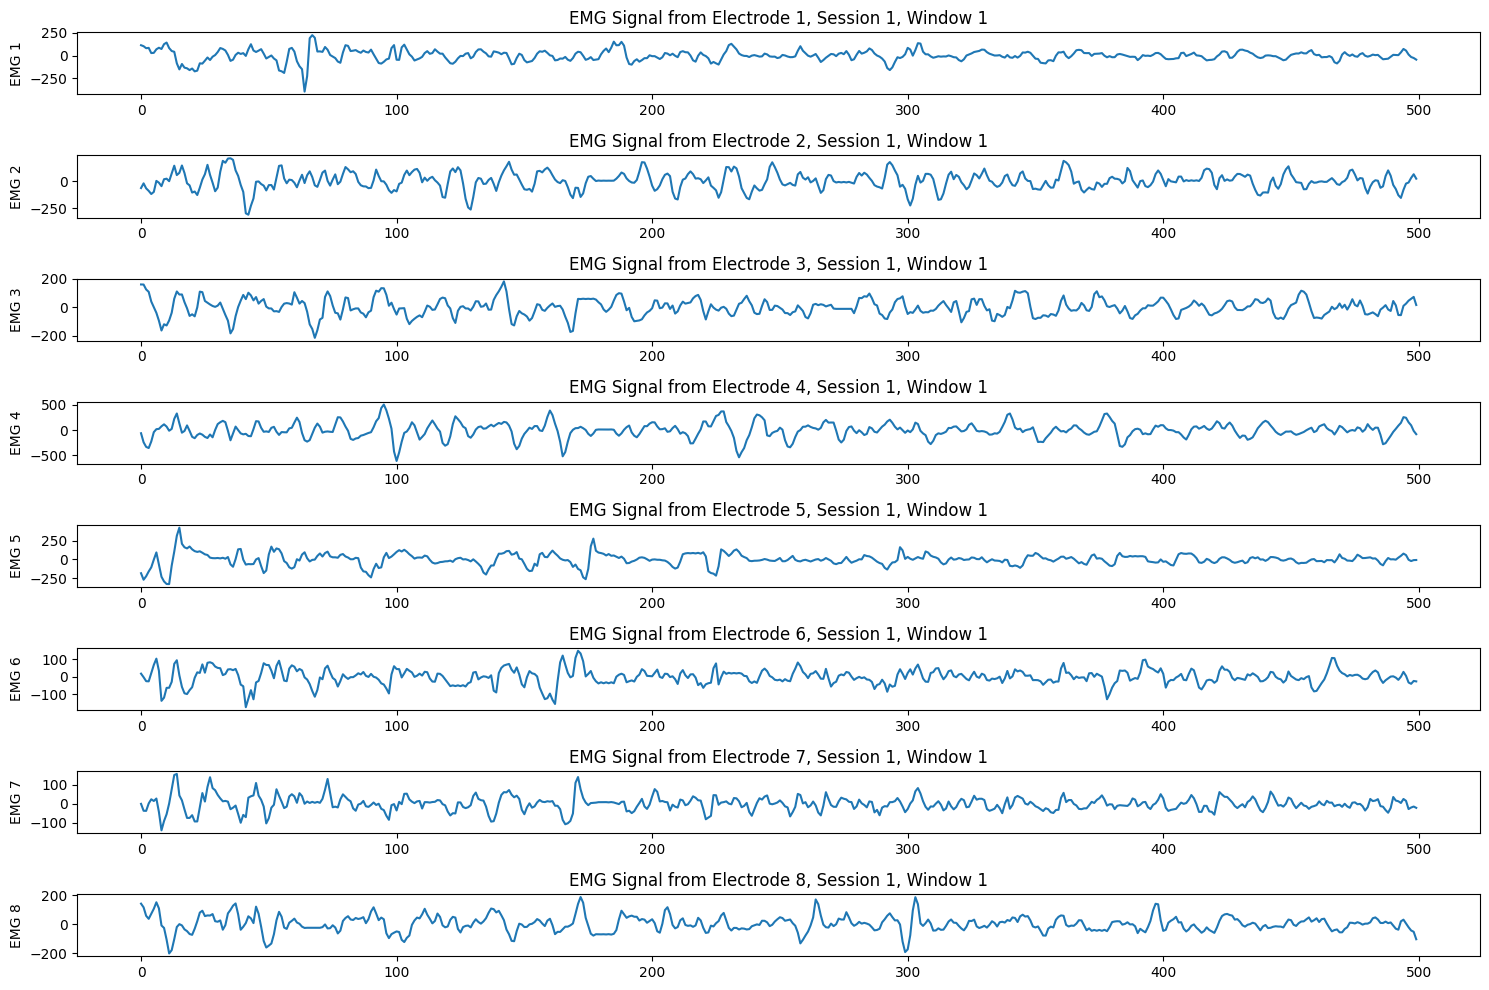

In [4]:
# Examine the test data
window_id = 0

# Plot EMG signals from one window
plt.figure(figsize=(15, 10))
for electrode in range(8):
    plt.subplot(8, 1, electrode+1)
    plt.plot(guided_test_X[session_id, window_id, electrode, :])
    plt.ylabel(f'EMG {electrode+1}')
    plt.title(f'EMG Signal from Electrode {electrode+1}, Session {session_id+1}, Window {window_id+1}')
    
plt.tight_layout()
plt.show()

This is the single 500-sample window from the test data. Here this window shos more uniform activity across the entire segment rather than the clear transitions seen in the training data.

The relative signal strengths across electrodes are consistent with what was seen in the training data.

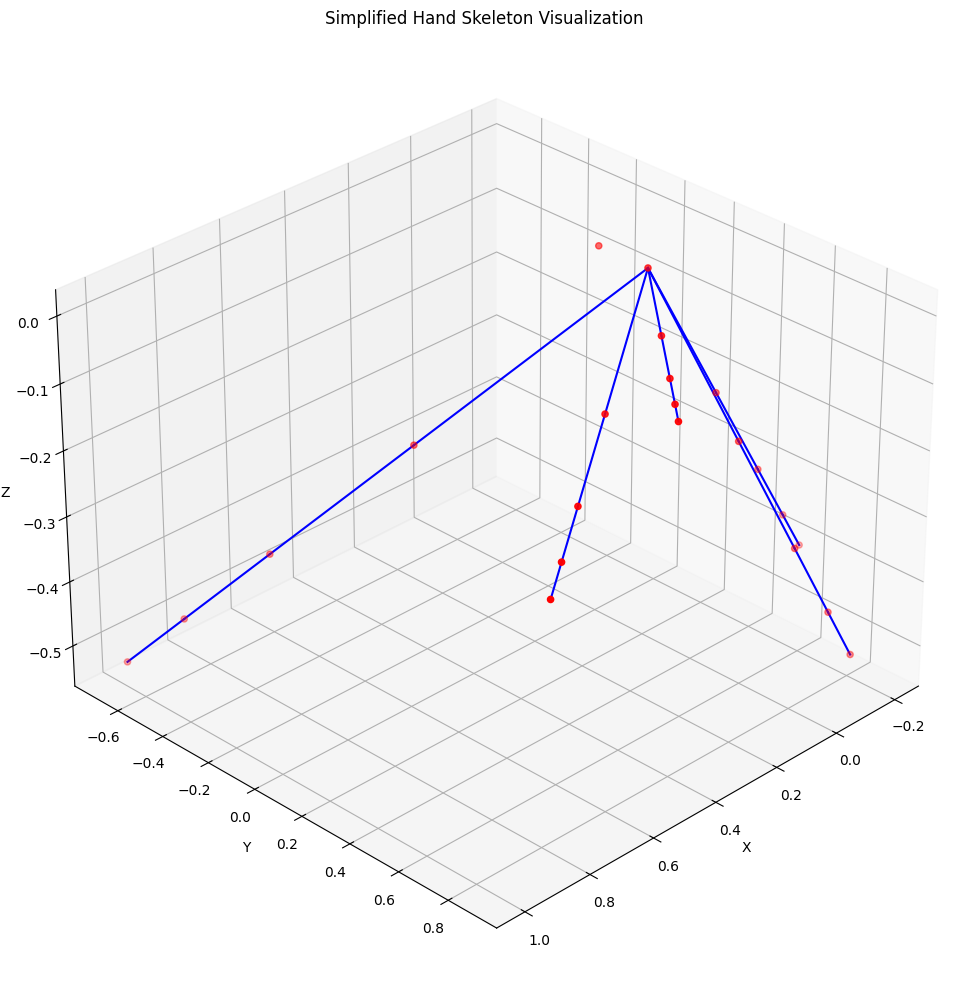

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Use the same create_hand_skeleton function...

# Get hand skeleton
points, lines = create_hand_skeleton(joint_angles)

# Create plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the joints
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o')

# Plot the connections
for line in lines:
    ax.plot([points[line[0], 0], points[line[1], 0]],
            [points[line[0], 1], points[line[1], 1]],
            [points[line[0], 2], points[line[1], 2]], 'b-')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simplified Hand Skeleton Visualization')
ax.view_init(elev=30, azim=45)  # Set viewing angle

plt.tight_layout()
plt.savefig('hand_skeleton_matplotlib.png', dpi=300)
plt.show()

In [6]:
def create_windows_with_overlap(data, window_size=500, overlap_percent=50):
    """
    Create overlapping windows from continuous EMG data.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data with shape (session, electrode/joint, time)
    window_size : int
        Size of each window in samples
    overlap_percent : float
        Percentage of overlap between consecutive windows (0-100)
    
    Returns:
    --------
    windows : numpy.ndarray
        Windowed data with shape (n_windows_total, electrode/joint, window_size)
    window_indices : list of tuples
        List containing (session_idx, window_start_idx, window_end_idx) for each window
    """
    n_sessions, n_channels, n_samples = data.shape
    
    # Calculate step size based on overlap percentage
    step_size = int(window_size * (1 - overlap_percent/100))
    
    windows = []
    window_indices = []
    
    # Process each session separately
    for session_idx in range(n_sessions):
        # Calculate how many windows we can extract from this session
        n_windows = 1 + (n_samples - window_size) // step_size
        
        for window_idx in range(n_windows):
            # Calculate start and end indices
            start_idx = window_idx * step_size
            end_idx = start_idx + window_size
            
            # Make sure we don't exceed the data length
            if end_idx <= n_samples:
                # Extract window for all channels
                window = data[session_idx, :, start_idx:end_idx]
                windows.append(window)
                window_indices.append((session_idx, start_idx, end_idx))
    
    # Convert list of windows to numpy array
    windows = np.array(windows)
    
    return windows, window_indices

# Then you can use it like this:
X_windows, X_indices = create_windows_with_overlap(guided_X, window_size=500, overlap_percent=75)
y_windows, y_indices = create_windows_with_overlap(guided_y, window_size=500, overlap_percent=75)

print(f"Original data shape: {guided_X.shape}")
print(f"Windowed data shape: {X_windows.shape}")
print(f"Number of windows per session (approx): {len(X_indices) // 5}")

Original data shape: (5, 8, 230000)
Windowed data shape: (9185, 8, 500)
Number of windows per session (approx): 1837


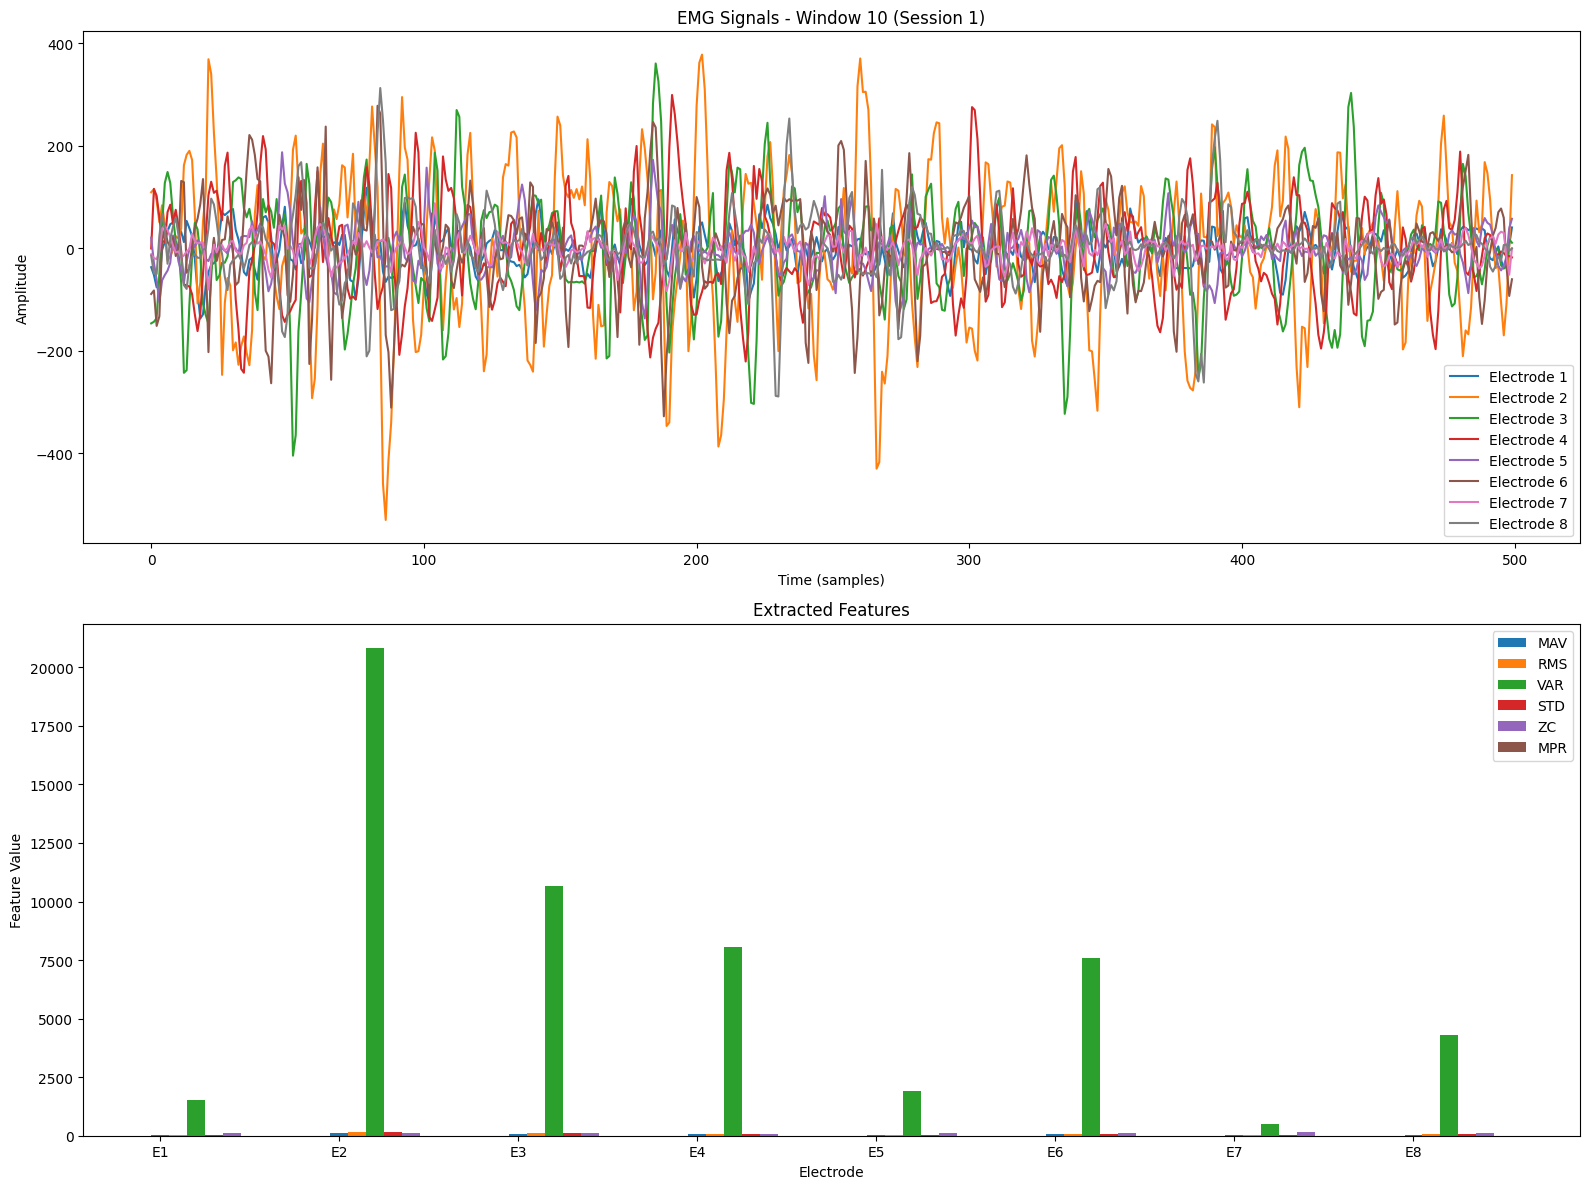

Extracted 48 features from 9185 windows


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create windows with overlap - proper implementation
def create_windows_with_overlap(data, window_size=500, overlap_percent=50):
    """
    Create overlapping windows from continuous EMG data.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data with shape (session, electrode/joint, time)
    window_size : int
        Size of each window in samples
    overlap_percent : float
        Percentage of overlap between consecutive windows (0-100)
    
    Returns:
    --------
    windows : numpy.ndarray
        Windowed data with shape (n_windows_total, electrode/joint, window_size)
    window_indices : list of tuples
        List containing (session_idx, window_start_idx, window_end_idx) for each window
    """
    n_sessions, n_channels, n_samples = data.shape
    
    # Calculate step size based on overlap percentage
    step_size = int(window_size * (1 - overlap_percent/100))
    
    windows = []
    window_indices = []
    
    # Process each session separately
    for session_idx in range(n_sessions):
        # Calculate how many windows we can extract from this session
        n_windows = 1 + (n_samples - window_size) // step_size
        
        for window_idx in range(n_windows):
            # Calculate start and end indices
            start_idx = window_idx * step_size
            end_idx = start_idx + window_size
            
            # Make sure we don't exceed the data length
            if end_idx <= n_samples:
                # Extract window for all channels
                window = data[session_idx, :, start_idx:end_idx]
                windows.append(window)
                window_indices.append((session_idx, start_idx, end_idx))
    
    # Convert list of windows to numpy array
    windows = np.array(windows)
    
    return windows, window_indices

# Function to calculate time-domain features for one window
def extract_time_domain_features(window):
    """
    Extract common time-domain features from a window of EMG data.
    
    Parameters:
    -----------
    window : numpy.ndarray
        Window of EMG data with shape (n_channels, window_size)
    
    Returns:
    --------
    features : numpy.ndarray
        Feature vector with shape (n_channels * n_features,)
    """
    n_channels, window_size = window.shape
    features = []
    
    for channel in range(n_channels):
        channel_data = window[channel, :]
        
        # Mean Absolute Value (MAV)
        mav = np.mean(np.abs(channel_data))
        
        # Root Mean Square (RMS)
        rms = np.sqrt(np.mean(channel_data**2))
        
        # Variance
        var = np.var(channel_data)
        
        # Standard Deviation
        std = np.std(channel_data)
        
        # Zero Crossing (ZC)
        zc = np.sum(np.diff(np.signbit(channel_data).astype(int)) != 0)
        
        # Myopulse Percentage Rate (MPR)
        threshold = np.std(channel_data)
        mpr = np.mean(np.abs(channel_data) > threshold)
        
        # Add all features for this channel
        channel_features = [mav, rms, var, std, zc, mpr]
        features.extend(channel_features)
    
    return np.array(features)

# Create windows
X_windows, X_indices = create_windows_with_overlap(guided_X, window_size=500, overlap_percent=75)
y_windows, y_indices = create_windows_with_overlap(guided_y, window_size=500, overlap_percent=75)

# Extract features for all windows
X_features = np.array([extract_time_domain_features(window) for window in X_windows])

# Visualize one window and its features
window_idx = 10  # Choose a window to visualize

plt.figure(figsize=(16, 12))

# Plot the EMG data for this window
plt.subplot(2, 1, 1)
for channel in range(X_windows.shape[1]):
    plt.plot(X_windows[window_idx, channel, :], label=f'Electrode {channel+1}')
plt.legend()
plt.title(f'EMG Signals - Window {window_idx} (Session {X_indices[window_idx][0]+1})')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')

# Plot the features for this window
plt.subplot(2, 1, 2)
feature_names = ['MAV', 'RMS', 'VAR', 'STD', 'ZC', 'MPR']
n_channels = X_windows.shape[1]
n_features = len(feature_names)
features = X_features[window_idx].reshape(n_channels, n_features)

for i, feature_name in enumerate(feature_names):
    plt.bar(np.arange(n_channels) + i*0.1, features[:, i], width=0.1, label=feature_name)
    
plt.xticks(np.arange(n_channels), [f'E{i+1}' for i in range(n_channels)])
plt.legend()
plt.title('Extracted Features')
plt.xlabel('Electrode')
plt.ylabel('Feature Value')

plt.tight_layout()
plt.savefig('window_and_features.png')
plt.show()

print(f"Extracted {X_features.shape[1]} features from {X_features.shape[0]} windows")